# Data Import

In [1]:
virtual_env = "False"

In [2]:
# Parameters
execution_date = "2024-05-21 14:41:55.008124+00:00"
virtual_env = "True"


In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if virtual_env == "True":
    con = sqlite3.connect("/mnt/02-Data_Curation/unified.db")
else:
    con = sqlite3.connect("../02-Data_Curation/unified.db")
    
cur = con.cursor()

df = pd.read_sql_query("SELECT * FROM prod", con)
df

,id,name,AB,description,OX,source,seq,valid
0,ADAM_2177,InverPep_ADAM_2177,1,None,alien,InverPep.fasta,GLFNVFKGLKTAGKHVAGSLLNQLKCKVSGGC,yes
1,DBAASP13663,"HistoneH2A(1-21),Fi-Histin",1,None,alien,InverPep.fasta,SRSSRAGLQFPVGRIHRLLRK,yes
2,DBAASP729,Histatin5(5-22),1,None,alien,InverPep.fasta,KRHHGYKRKFHEKHHSHR,yes
3,DBAASP644,Gaegurin5(1-11)[F1W],1,None,alien,InverPep.fasta,WLGALFKVASK,yes
4,ADAM_0664,InverPep_ADAM_0664,1,None,alien,InverPep.fasta,DLWNSIKDMAAAAGRAALNAVTGMVNQ,yes
...,...,...,...,...,...,...,...,...
12823,Q7M463,SCK6_MESMA,0,Neurotoxin BmK A3-6,Mesobuthus martensii OX=34649,uniprot_swissprot.fasta,LPYPVNCKTECECVMCGLGIICKQCYYQQ,yes
12824,Q7NSS5,Y3345_CHRVO,0,UPF0434 protein CV_3345,Chromobacterium violaceum (strain ATCC 12472 /...,uniprot_swissprot.fasta,MDAKFLEILVCPLCKGPLVFDKSKDELICKGDRLAFPIKDGIPMML...,yes
12825,Q8QHM9,Y56_SIRV1,0,Uncharacterized protein 56,Sulfolobus islandicus rod-shaped virus 1 OX=15...,uniprot_swissprot.fasta,MKKEIQVQGVRYYVESEDDLVSVAHELAKMGYTVQQIANALGVSER...,yes
12826,Q9R4N8,RL33_BREVE,0,Large ribosomal subunit protein bL33 (Fragment),Brevundimonas vesicularis OX=41276 GN=rpmG,uniprot_swissprot.fasta,CKPASIKIRLNSTADTGFYV,yes


# Compare Positive/negative Data
To ensure a model does not determine the AB of a seq based on something else the seq information we try to match as many properties of data. Goal is to avoid that we train a model which just discriminates based on length or some property similiar.

In [4]:
pd.read_sql_query("SELECT COUNT(*), AB FROM prod GROUP BY AB", con)

,COUNT(*),AB
0,5845,0
1,6983,1


This is close enough to a 1:1 ratio. This ensures that potential models do not determine the activity by guessing based on length.

# Compare lengths


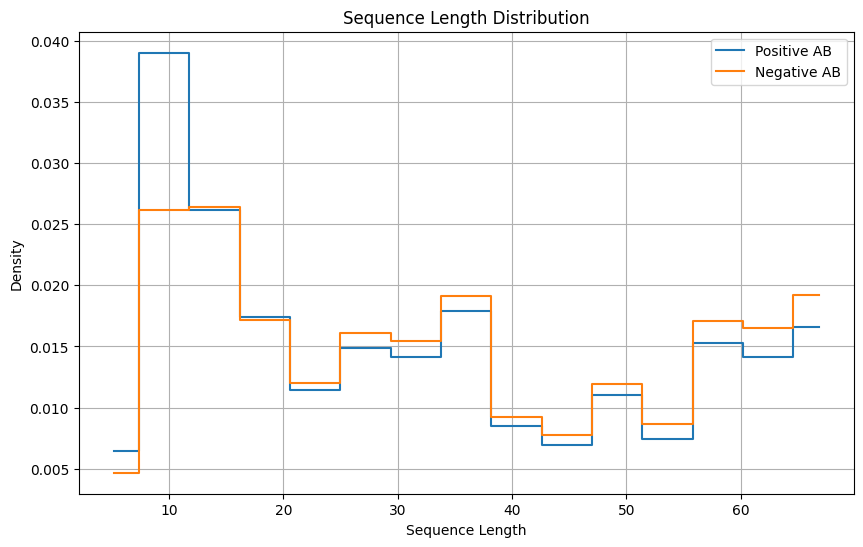

In [5]:
# Calculate lengths
df['seq_length'] = df['seq'].apply(lambda x: len(x))

# Separate by AB values
positive = df[df['AB'] == 1]
negative = df[df['AB'] == 0]

# Calculate histogram data
hist_data_pos, bin_edges_pos = np.histogram(positive['seq_length'], bins=15, density=True)
hist_data_neg, bin_edges_neg = np.histogram(negative['seq_length'], bins=15, density=True)

# Midpoints of bins
bin_centers_pos = 0.5 * (bin_edges_pos[1:] + bin_edges_pos[:-1])
bin_centers_neg = 0.5 * (bin_edges_neg[1:] + bin_edges_neg[:-1])

# Create line plot
plt.figure(figsize=(10, 6))
plt.plot(bin_centers_pos, hist_data_pos, label='Positive AB', drawstyle='steps-mid')
plt.plot(bin_centers_neg, hist_data_neg, label='Negative AB', drawstyle='steps-mid')
plt.legend()
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Density')
plt.grid(True)
plt.show()

The length destribution is roughly the same. Meaning models cant guess based on sequence length.

# AA make up
Goal check wether AA make up is the same with positive AB and negative AB.

   mean_pos   std_pos  mean_neg   std_neg
A  0.069492  0.073380  0.070235  0.067549
C  0.054697  0.072554  0.062752  0.085332
D  0.025859  0.044491  0.050872  0.052559
E  0.032890  0.049600  0.048998  0.054028
F  0.045273  0.057649  0.044401  0.051582
G  0.079913  0.073647  0.082883  0.065455
H  0.021889  0.042170  0.018449  0.031171
I  0.056303  0.059154  0.046609  0.049084
K  0.113774  0.108401  0.066495  0.063513
L  0.100812  0.097685  0.076560  0.067975
M  0.014615  0.028104  0.023826  0.033158
N  0.034931  0.041645  0.043473  0.044845
P  0.044108  0.067637  0.058901  0.065090
Q  0.027659  0.040941  0.032269  0.043282
R  0.079323  0.102894  0.056227  0.069906
S  0.051709  0.054704  0.062346  0.053929
T  0.038540  0.047193  0.047324  0.046754
V  0.055001  0.057482  0.058727  0.053250
W  0.028889  0.066128  0.014460  0.030343
Y  0.024324  0.040157  0.034194  0.042498


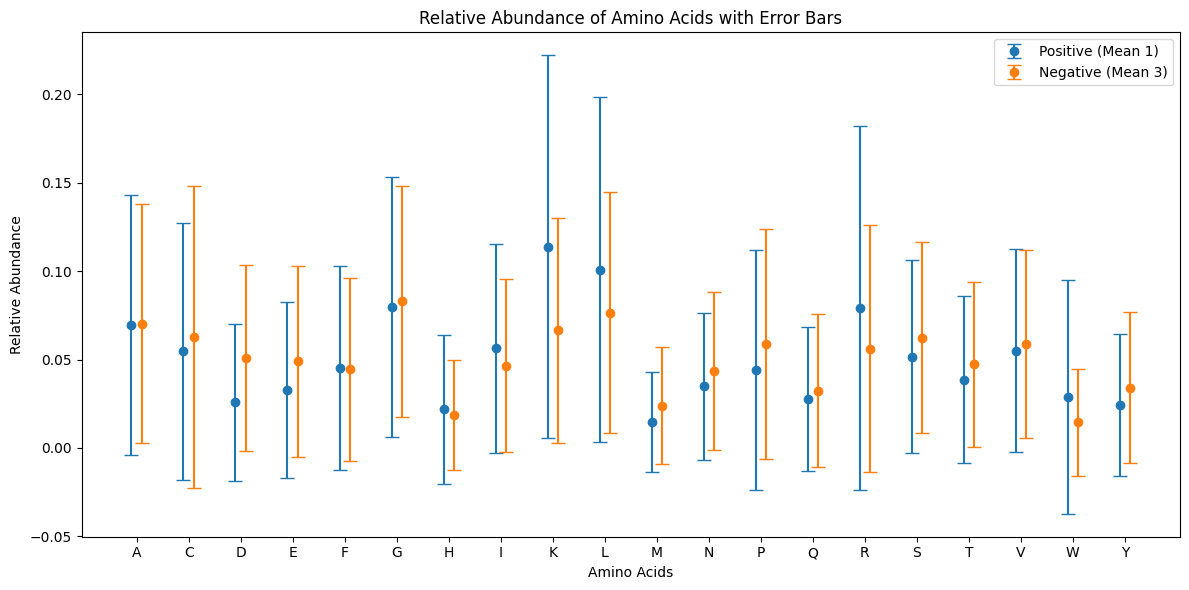

In [6]:
# Calculate relative abundance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is provided
df_backup = df.copy()

# List of amino acids
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')

# Function to calculate relative abundance of amino acids
def calculate_abundance(seq):
    abundance = {aa: 0 for aa in amino_acids}
    for aa in seq:
        if aa in abundance:
            abundance[aa] += 1
    seq_length = len(seq)
    if seq_length > 0:
        for aa in abundance:
            abundance[aa] /= seq_length
    return abundance

# Apply the function to each sequence and create a new DataFrame
abundance_df = df['seq'].apply(calculate_abundance).apply(pd.Series)

# Merge the new DataFrame with the original DataFrame
result_df = pd.concat([df['AB'], abundance_df], axis=1)

# Separate positive and negative groups
positive = result_df[result_df['AB'] == 1].drop(columns=['AB']).reset_index(drop=True)
negative = result_df[result_df['AB'] == 0].drop(columns=['AB']).reset_index(drop=True)

n_pos = len(positive)
n_neg = len(negative)

# Calculate means and standard deviations
df_local = pd.concat([positive.mean(), positive.std(), negative.mean(), negative.std()], axis=1)
df_local.columns = ['mean_pos', 'std_pos', 'mean_neg', 'std_neg']
df_local.index = amino_acids

print(df_local)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# X-axis positions for the amino acids
x = np.arange(len(df_local))

# Plotting data points and error bars
ax.errorbar(x - 0.1, df_local['mean_pos'], yerr=df_local['std_pos'], fmt='o', label='Positive (Mean 1)', capsize=5)
ax.errorbar(x + 0.1, df_local['mean_neg'], yerr=df_local['std_neg'], fmt='o', label='Negative (Mean 3)', capsize=5)

# Setting the labels and title
ax.set_xlabel('Amino Acids')
ax.set_ylabel('Relative Abundance')
ax.set_title('Relative Abundance of Amino Acids with Error Bars')

# Setting the x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(df_local.index)

# Adding legend
ax.legend()

# Displaying the plot
plt.tight_layout()
plt.show()


Graphic shows no large deviation per amino acid postive vs negative.